# `wavdetect` duplicate source bug 


While working on reviewing the threads for CIAO 4.9 I came across a case where `wavdetect` outputs a source list with two
nearly identicical sources:  nearly identical `POS` locations but different properties.

There is a existing CIAO bug for a similar sounding report, [bug #13409: 'BUG: wavdetect - duplicate sources'](https://icxc.harvard.edu/pipe/ascds_help/2012/0565.html) although John's report doesn't specifically mention duplicate soures.  This came from the earlier L3 work so I'm presuming Stephen just used this to tag the topic for later evaluation.

I've spent some time debugging the `wrecon` code to try to identify what's going on.  

This is a writeup of what I've found. 

Based on this analysis, I believe this also to be the cause of [bug #13481: 'wavdetect nan psfsize'](https://icxc.harvard.edu/pipe/dsdevel/2014/0070.html) as I can see that the input psfmap has `NaN` values around the edge which are probably "migrating" in as part of the gradient-search algorithm described below.

Since I don't have all the files or input parameters I can't replicate the behavior in those other two reports (this behavior is very sensitive to the inputs used).



## Deconstructing  `wavdetect`

Based on an initial assesment, the issues we are seeing are in the source properties/reconstruction phase of the `wavdetect` process rather than on the detection of correlation maxima, ie the `wrecon` tool.


## Key points of `wrecon` algorithm

The `PSF_SIZE` values output from `wavdetect` are from the location of the _correlation maximum_ (`cormax`), **not** from the `POS(X,Y)` location.

The location of the `cormax` is not saved in the source list.

The source properties are computed from the pixels in the source _cell_.

There may infact be multiple `cormax` within a source _cell_.

The _cell_ is constructed by starting at `cormax`.  We lookup the `PSF_SIZE` at that location.  That size is used to determine the closest wavelet scale.  If the _flux_ at that wavelet scale at that location is greater than zero, then we have a source candidate.

> This is different than the common wisdom that `cormax` is filtered if it was only _detected_ at wavelet scales bigger than the PSF.

The wavelet scale size used to reconstruct the soure properties is not saved in the source list.

We use the location of `cormax` to find the local maximum in the _flux_ image.  This is done by starting at `cormax` and walking up the local gradient to the local flux max.  Typically this is a **short** trip.  The `cormax` and `fluxmax` usually overlap.  However, there are no constraints on the distance this algorithm is allowed to travel.

The location of the `fluxmax` is not saved in the source list.

Starting from the `fluxmax` we walk down the gradient until we hit a saddle point or flux<=0.  All those pixels are associated with the source, ie this is the source _cell_.

All other `cormax` found at all scales that fall within this _cell_ are marked as "processed" (and not considered further).



## What's happening in the example below?

There is a bright source that has a `cormax` at all wavelet scales.

There is a _nearby_ `cormax` at one wavelet scale (4).

The location of the bright source `cormax` has a `PSF_SIZE=13.3`.  This is _closest_ to wavelet scale=12.

The location of the nearby `cormax` has a `PSF_SIZE=14.1`.  This is _closest_ to wavelet scale=16.

The bright source is processed first.  It uses scale=12 to create it's _cell_ and the `fluxmax` is at the same location as the `cormax`.

At scale=12, the _cell_ does not extent out to the location of the nearby source `cormax`. There is a saddle point between them as you would expect for two nearby sources.  Since the cell does not cover the nearby source cormax, the nearby source is still availabe as a source candidate.

> If the nearby source had a `PSF_SIZE` closest to scale=12, then it would have been removed.

Eventually the nearby `cormax` is processed.  Even though it was only identified as a max at scale=4, the _flux_ at scale=16 is non-zero, therefore the nearby `cormax` is processed as a source candidate.

At scale=16, the flux from the bright source is blurred out enough that when the `local_max` routine starts at the location of the nearby source `cormax`, it travels over 35 pixels to the location of the bright source `fluxmax`.   

Now for this "new" nearby source, the scale=16 `flux` image is used to create the new source's _cell_ -- starting basically from the same location as the bright source.  

Since the scale=16 image is blurred out further than the scale=12 image the _cell_ is bigger, and the source properties are "bigger", eg `R` and `NPIXSOU`; however, the centroid of the pixels is basically the same, so we get the same `POS(X,Y)` position.

> There is a chicken-n-egg situation here.  We need to know the wavelet scale (and therefore the `PSF_SIZE`) 
> to determine which _flux_ image to use,  but the result may be that we find a `fluxmax` location 
> which would use a different wavelet scale.

Since the _cell_ for the bright and nearby source overlap, the output `cellimage` looks odd.  Only a sliver of the scale=12 is seen since it was processed first.  The nearby source processed at scale=16 was processed second is fully represented in the cellimage -- overwriting the many of the scale=12 values.


## Suggestions


Given the heuristic nature of the algorithm, making a change to the actual algorithm is tricky.  There may be unexpected,
unintented, undesireable side effects.  There could also be causality issues (order sources are processed may cause nondeterministic results).

At this point, I would suggest we include additional information in the wavdetect output:

- Add new vector column `CORRELATION_MAX(X_CORRELATION_MAX,Y_CORRELATION_MAX)`.  It should be in physical pixels
  (note: the values stored going from `wtransform` to `wrecon` are logical (or C-array)).  We do not need to 
  attach the same world coordinate system as the `POS` column.
  
- Add new vector column `FLUX_MAX(X_FLUX_MAX,Y_FLUX_MAX)`.  See above.  

- Add new vector column  `SCALES(X_WAVELET_SCALE,Y_WAVELET_SCALE)` which records the wavelet scale used to 
  construct the source cell.

These values are already available in the code, they just need to be saved.  The extra 48 bytes (6 cols * 8 byte doubles) per source is not considered significant.

With these values, users may be able to develop their own filters to help identify this kind of situation.  For example by checking the distance beween `CORRELATION_MAX` and `FLUX_MAX`. 

SDS will consult with Vinay and (if possible) Peter to review options for code changes that could suppress these duplicates and minimize the potential for dropping valid independent sources.



---

## Detailed Analysis


Below are the steps used to diagnose this issue (in addition to stepping through the code in the debugger).


### Create the `wavdetect` inputs.

I'm using OBSID=2233 which is used in the [reproject aspect thread](http://cxc.cfa.harvard.edu/ciao/threads/reproject_aspect/) 

I "discovered" this duplicate source when running this thread and having problems running `roi` since the source region it output was essentially NULL.



In [1]:
source /soft/ciao/bin/ciao.bash

CIAO configuration is complete... 
CIAO 4.9 Friday, December  2, 2016
  bindir      : /soft/ciao-4.9/bin
  CALDB       : 4.7.3


In [2]:
/bin/rm -rf tmpdir
mkdir -p tmpdir

In [3]:
/bin/rm -rf 2233
download_chandra_obsid 2233


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  readme   ascii      11 Kb  ####################          < 1 s  1736.4 kb/s
  oif      fits       25 Kb  ####################          < 1 s  3820.7 kb/s
  vv       pdf        40 Kb  ####################          < 1 s  5231.1 kb/s
  cntr_img fits       88 Kb  ####################          < 1 s  10758.3 kb/s
  cntr_img jpg       681 Kb  ####################          < 1 s  36882.5 kb/s
  evt2     fits        8 Mb  ####################          < 1 s  68603.8 kb/s
  full_img fits       66 Kb  ####################          < 1 s  7741.2 kb/s
  full_img jpg        67 Kb  ####################          < 1 s  8141.2 kb/s
  bpix     fits       56 Kb  ####################          < 1 s  6873.8 kb/s
  fov      fits        6 Kb  ####################          < 1 s  848.0 kb/s
  eph1     fits      281 Kb  ####################          < 

In [4]:
chandra_repro 2233 2233/repro clob+


Processing input directory '/lenin1.real/Bugs/Wavdetect/DupSrc/2233'

Resetting afterglow status bits in evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...

Running acis_process_events to reprocess the evt1.fits file...
Filtering the evt1.fits file by grade and status and time...
Applying the good time intervals from the flt1.fits file...
The new evt2.fits file is: /lenin1.real/Bugs/Wavdetect/DupSrc/2233/repro/acisf02233_repro_evt2.fits

Updating the event file header with chandra_repro HISTORY record
Creating FOV file...
Setting observation-specific bad pixel file in local ardlib.par.

Cleaning up intermediate files

         /lenin1.real/Bugs/Wavdetect/DupSrc/2233/repro/acisf02233_repro_bpix1.fits
         Run 'punlearn ardlib' when analysis of this dataset completed.

The data have been reprocessed.
Start your analysis with the new products in
/lenin1.real/Bugs/Wavdetect/DupSrc/2233/repro



In [5]:
fluximage 2233/repro/acisf02233_repro_evt2.fits out=acisf02233 bin=1 clob+ tmpdir=./tmpdir

Running fluximage
Version: 12 September 2016

Using CSC ACIS broad science energy band.
Aspect solution 2233/repro/pcadf099202533N003_asol1.fits found.
Bad-pixel file 2233/repro/acisf02233_repro_bpix1.fits found.
Mask file 2233/repro/acisf02233_000N003_msk1.fits found.

The output images will have 4006 by 3168 pixels, pixel size of 0.492 arcsec,
    and cover x=2441.5:6447.5:1,y=2677.5:5845.5:1.

Running tasks in parallel with 4 processors.
Creating aspect histograms for obsid 2233
# DMCOPY (CIAO 4.9): WARNING: Creating large image: 102 MB. Current max set at 50 MB.
Increase maximum using [opt mem=n] or increase blocking to reduce size.
Creating 5 instrument maps for obsid 2233
Creating 5 exposure maps for obsid 2233
Combining 5 exposure maps for obsid 2233
Thresholding data for obsid 2233
Exposure-correcting image for obsid 2233

The following files were created:

 The clipped counts image is:
     acisf02233_broad_thresh.img

 The clipped exposure map is:
     acisf02233_broad_thresh

In [6]:
mkpsfmap acisf02233_broad_thresh.img acisf02233_broad.psfmap energy=2.3 spectrum= ecf=0.9 units=arcsec mode=h clob+

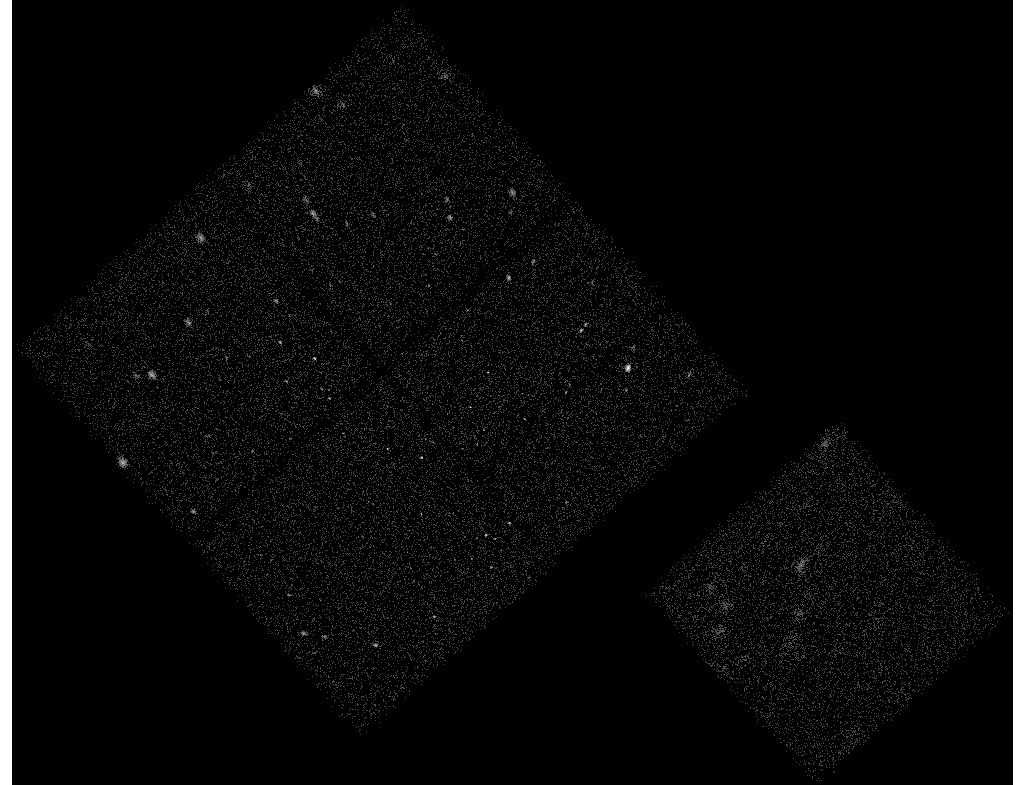

In [7]:
ds9 -geometry 1024x832 acisf02233_broad_thresh.img -scale log -block 4 \
  -view panner off -view info off -view magnifier off -view buttons off -view colorbar off \
  -saveimage ds9_01.png -quit 

display < ds9_01.png

---

## Run `wavdetect`

I need to keep the intermediate files, so I run `wtransform` and `wrecon` seprately.



In [8]:
pset wtransform \
  infile=acisf02233_broad_thresh.img \
  srclist=./tmpdir/wdlenin3728_srclist_stk \
  correl=./tmpdir/wdlenin3728_correl_stk \
  nbkg=./tmpdir/wdlenin3728_nbkg_stk \
  expcor=fast expthresh=0.1 bkgtime=0 bkginput= bkgerrinput=no \
  expfile=acisf02233_broad_thresh.expmap \
  xscales="1.4 2 4 8 12 16 24 32" yscales=")xscales" \
  correlerr=n nbkgerr=y  maxiter=2 iterstop=0.0001  \
  sigthresh=1e-06  bkgsigthresh=0.001 \
  falsesrc=-1 \
  clobber=yes

wtransform mode=h clob+ verb=1

input file: acisf02233_broad_thresh.img
exposure file: acisf02233_broad_thresh.expmap
correlation maxima output stack: ./tmpdir/wdlenin3728_srclist_stk
correlation image output stack: ./tmpdir/wdlenin3728_correl_stk
normalized background output stack: ./tmpdir/wdlenin3728_nbkg_stk
plain background output stack: 
threshold output stack: 
output source list stack: ./tmpdir/wdlenin3728_srclist_stk
output correlation stack: ./tmpdir/wdlenin3728_correl_stk
output normalized background stack: ./tmpdir/wdlenin3728_nbkg_stk
number of image pixels = 12691008
inferred exposure time = 17474942.000000
inferred exposure threshold = 1747494.250000
number above expthresh = 5468991
current X scale = 1.400000
current Y scale = 1.400000
current X scale = 2.000000
current Y scale = 2.000000
current X scale = 4.000000
current Y scale = 4.000000
current X scale = 8.000000
current Y scale = 8.000000
current X scale = 12.000000
current Y scale = 12.000000
current X scale = 16.000000
current Y scale = 16.0000

---

and now run `wrecon`


In [9]:
pset wrecon \
  infile=acisf02233_broad_thresh.img \
  expfile=acisf02233_broad_thresh.expmap \
  psffile=acisf02233_broad.psfmap \
  correl=./tmpdir/wdlenin3728_correl_stk \
  srclist=./tmpdir/wdlenin3728_srclist_stk \
  nbkg=./tmpdir/wdlenin3728_nbkg_stk  \
  fluxfile=./tmpdir/wd_flux_stk  \
  xscales="1.4 2 4 8 12 16 24 32" yscales=")xscales" \
  expthresh=0.1  bkgtime=0 exptime=0  \
  sourcefile=acisf02233_broad.src  \
  scellfile=acisf02233_broad.cell \
  imagefile=acisf02233_broad.recon  \
  defnbkgfile=acisf02233_broad.nbkg \
  bkginput= bkgerrinput=no  \
  fluxscales="1 2 3 4 5 6 7 8"  \
  log=no regfile=  ellsigma=3   \
  clobber=yes 

wrecon mode=h verb=1 clob+ 

Input image file: acisf02233_broad_thresh.img
Input correlation maxima stack: ./tmpdir/wdlenin3728_srclist_stk
Input correlation image stack: ./tmpdir/wdlenin3728_correl_stk
Input background stack: ./tmpdir/wdlenin3728_nbkg_stk
Input exposure map map: acisf02233_broad_thresh.expmap
Output flux stack: ./tmpdir/wd_flux_stk
Output background image: acisf02233_broad.nbkg
Output source image: acisf02233_broad.recon
Output source cell image: acisf02233_broad.cell
Output source list file: acisf02233_broad.src
Output source regions file: 


## Inspect the results

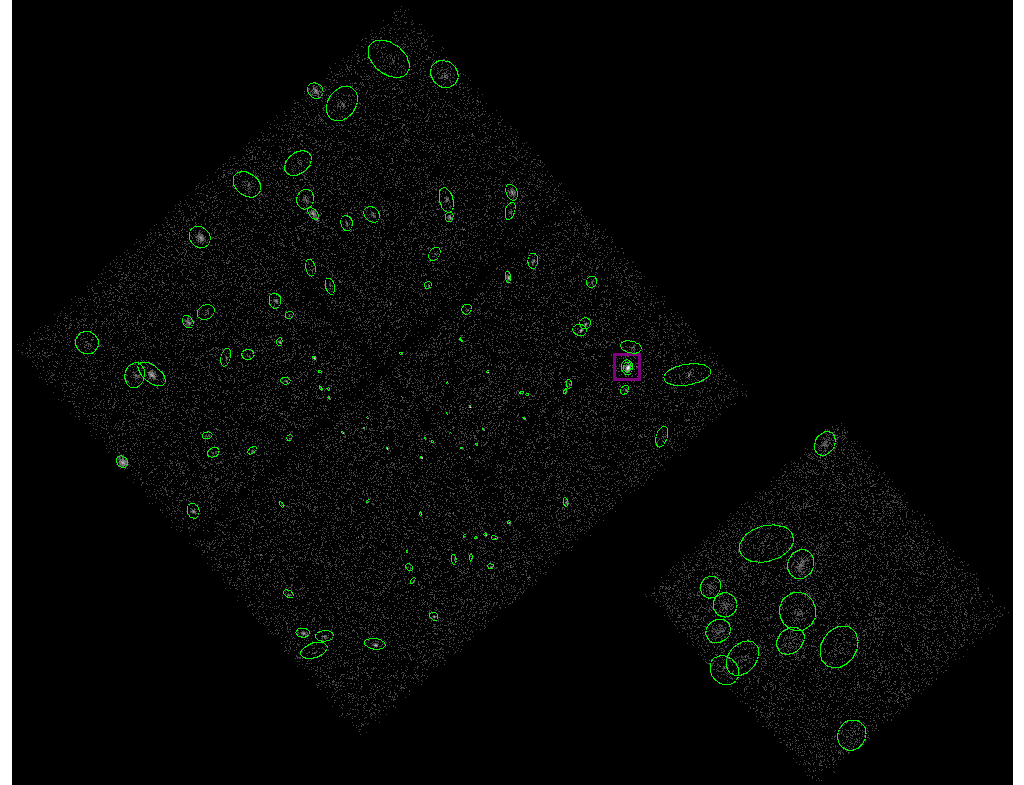

In [10]:
ds9 -geometry 1024x832 acisf02233_broad_thresh.img -scale log -block 4 \
  -view panner off -view info off -view magnifier off -view buttons off -view colorbar off \
  -region acisf02233_broad.src \
  -regions command "physical;box(4906,4361,100,100) # color=purple width=3" \
  -saveimage ds9_02.png -quit 

display < ds9_02.png

There is an ~dup source at 4906,4361 (in the purple box).

In [11]:
dmlist acisf02233_broad.src"[cols x,y,r,psf_size,npixsou][(x,y)=circle(4906,4361,1)]" data,clean

#  POS(X,Y)                                 R[2]                                     PSF_SIZE             NPIXSOU
      4906.0868761553      4361.3844731978        20.403760910        15.1911373138        13.2910089493       3610
      4906.1481481481      4361.3447971781        29.9333763123        22.7153568268        14.1166629791       6831


## _cormax_ locations

To begin we need to see where `wtransform` found correlation maximum.  These are stored in the temporary `*_xxxxxx_yyyyyy.fits` files (where `x` and `y` are the wavelet scales in that direction).


> wavdetect uses logical (or sometimg 0-based C array indexes) so we need to use look for something at/around

In [12]:
punlearn dmcoords
dmcoords acisf02233_broad_thresh.img x=4906 y=4361 op=sky
pget dmcoords logicalx logicaly

2465
1684


---

## What's going on?



Here's what's happening.  The strong off-axis pt src shows up in all the correlation files.


In [13]:
dmlist "tmpdir/*thresh_??????_??????.fits[(x_correl_max,y_correl_max)=circle(2465,1684,2)]" data,clean

#  X_CORREL_MAX         Y_CORREL_MAX         CORREL_MAX           THR_MAX
               2465.0               1685.0       121.3602066040        41.1977920532
#  X_CORREL_MAX         Y_CORREL_MAX         CORREL_MAX           THR_MAX
               2465.0               1684.0       250.4837341309        45.4885864258
#  X_CORREL_MAX         Y_CORREL_MAX         CORREL_MAX           THR_MAX
               2465.0               1684.0          693.0156250        45.2765464783
#  X_CORREL_MAX         Y_CORREL_MAX         CORREL_MAX           THR_MAX
               2465.0               1684.0      1318.9907226562        28.8393459320
#  X_CORREL_MAX         Y_CORREL_MAX         CORREL_MAX           THR_MAX
               2465.0               1684.0      1629.6501464844        24.3002967834
#  X_CORREL_MAX         Y_CORREL_MAX         CORREL_MAX           THR_MAX
               2465.0               1684.0      1786.8096923828        29.1531410217
#  X_CORREL_MAX         Y_CORREL_MAX         C

But in one, the scale=4 files, there is a 2nd correlation max is that _nearby_


In [14]:
dmlist "tmpdir/*thresh_???040_???040.fits[(x_correl_max,y_correl_max)=circle(2465,1684,40)]" data,clean

#  X_CORREL_MAX         Y_CORREL_MAX         CORREL_MAX           THR_MAX
               2465.0               1684.0          693.0156250        45.2765464783
               2500.0               1689.0        10.5595388412        10.2600002289


We can look at that location in the `_correl.fits` files as well as the `_flux.fits` files.

In [15]:
# Convert the correlation max to a region file

list_file()
{

infile=$1
outfile=`echo $infile | sed 's,fits$,reg,' `

dmlist "${infile}[cols x_correl_max,y_correl_max]" data,clean | \
  grep -vi x_correl_max | \
  awk '{print "image;point("$1","$2") # point=circle"}' > $outfile
  
}


for ff in tmpdir/acisf02233_broad_thresh_??????_??????.fits
do
  list_file $ff
done


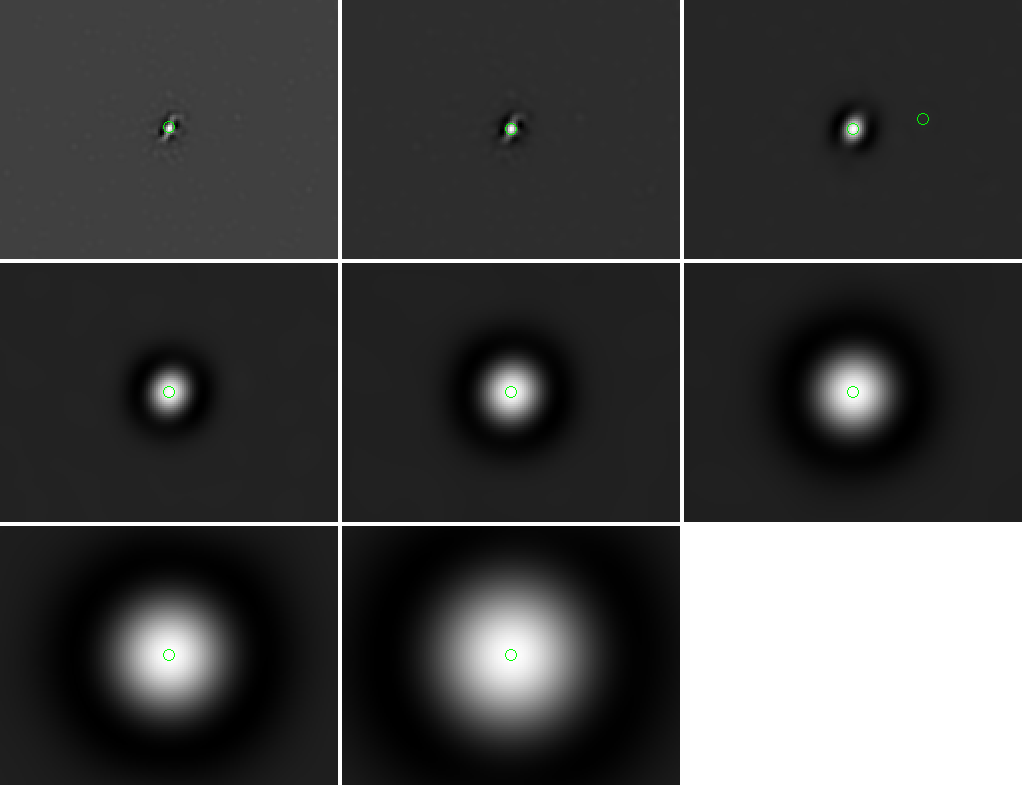

In [24]:
ds9 -geometry 1024x832 -scale linear -zoom 2 \
  -view panner off -view info off -view magnifier off -view buttons off -view colorbar off \
  tmpdir/acisf02233_broad_thresh_000014_000014_correl.fits -region tmpdir/acisf02233_broad_thresh_000014_000014.reg \
  tmpdir/acisf02233_broad_thresh_000020_000020_correl.fits -region tmpdir/acisf02233_broad_thresh_000020_000020.reg \
  tmpdir/acisf02233_broad_thresh_000040_000040_correl.fits -region tmpdir/acisf02233_broad_thresh_000040_000040.reg \
  tmpdir/acisf02233_broad_thresh_000080_000080_correl.fits -region tmpdir/acisf02233_broad_thresh_000080_000080.reg \
  tmpdir/acisf02233_broad_thresh_000120_000120_correl.fits -region tmpdir/acisf02233_broad_thresh_000120_000120.reg \
  tmpdir/acisf02233_broad_thresh_000160_000160_correl.fits -region tmpdir/acisf02233_broad_thresh_000160_000160.reg \
  tmpdir/acisf02233_broad_thresh_000240_000240_correl.fits -region tmpdir/acisf02233_broad_thresh_000240_000240.reg \
  tmpdir/acisf02233_broad_thresh_000320_000320_correl.fits -region tmpdir/acisf02233_broad_thresh_000320_000320.reg \
  -pan to 2465 1684 image -match frame image \
  -saveimage png ds9_03.png -quit

display < ds9_03.png


Going left-to-right, top-to-bottom, these are the correlation images, `_correl.fits` for wavelet scales = 1.4, 2.0, **4.0**, 8.0, 12.0, 16.0, 24.0, 32.0.

The image with 2 correlation maxes is for wavelet scale=4.0.



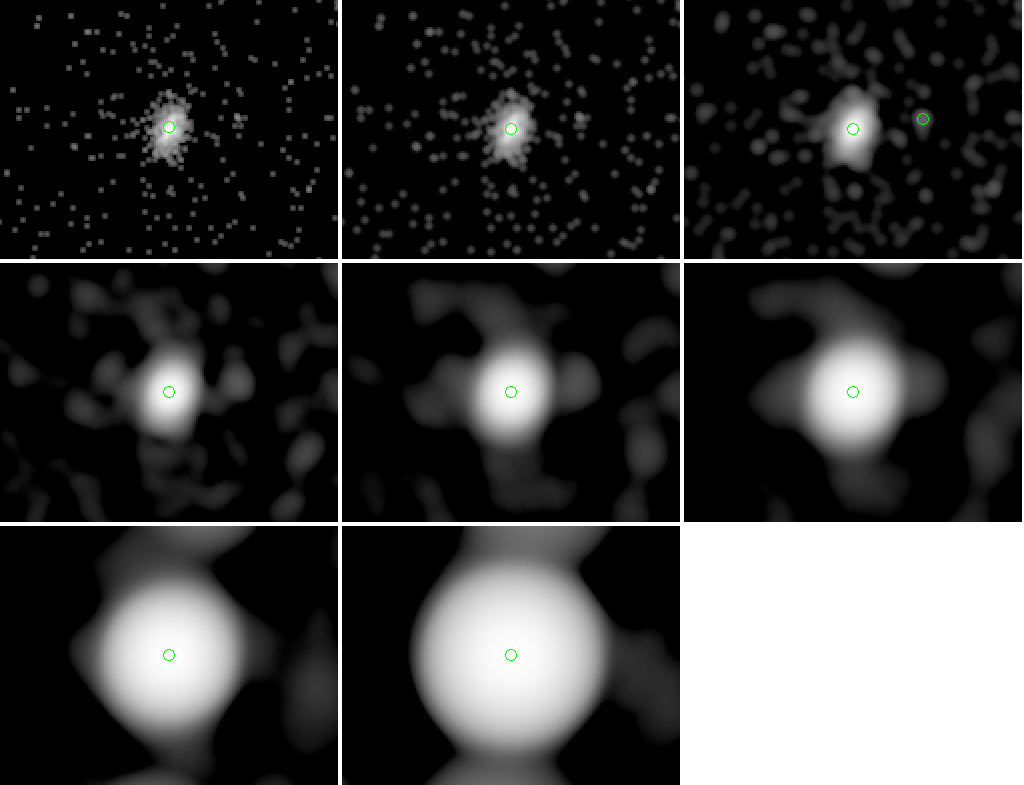

In [17]:
ds9 -geometry 1024x832 -scale log -zoom 2 \
  -view panner off -view info off -view magnifier off -view buttons off -view colorbar off \
  tmpdir/acisf02233_broad_thresh_000014_000014_flux.fits -region tmpdir/acisf02233_broad_thresh_000014_000014.reg \
  tmpdir/acisf02233_broad_thresh_000020_000020_flux.fits -region tmpdir/acisf02233_broad_thresh_000020_000020.reg \
  tmpdir/acisf02233_broad_thresh_000040_000040_flux.fits -region tmpdir/acisf02233_broad_thresh_000040_000040.reg \
  tmpdir/acisf02233_broad_thresh_000080_000080_flux.fits -region tmpdir/acisf02233_broad_thresh_000080_000080.reg \
  tmpdir/acisf02233_broad_thresh_000120_000120_flux.fits -region tmpdir/acisf02233_broad_thresh_000120_000120.reg \
  tmpdir/acisf02233_broad_thresh_000160_000160_flux.fits -region tmpdir/acisf02233_broad_thresh_000160_000160.reg \
  tmpdir/acisf02233_broad_thresh_000240_000240_flux.fits -region tmpdir/acisf02233_broad_thresh_000240_000240.reg \
  tmpdir/acisf02233_broad_thresh_000320_000320_flux.fits -region tmpdir/acisf02233_broad_thresh_000320_000320.reg \
  -pan to 2465 1684 image -match frame image \
  -saveimage png ds9_04.png -quit

display < ds9_04.png


---

## Debugging 


Stepping through the code in the debugger there are a few things to note

## Correlation max, PSF size, scale connection

Okay, so looking at the output, we see that even though the source positions (x,y) are the same, the `PSF_SIZE` values are different.  

This is suspicious.

It turns out that the `PSF_SIZE` are **not** for the source `X,Y`, but are instead for the location of the correlation maximum, which is not saved.

It is also the case that the correlation max at `(2465,1684)` with `PSF_SIZE=13.29` is _closest_ in the `sqrt(2)` sense to `scale=12`.  Whereas the correlation max at `(2500,1689)` with `PSF_SIZE=14.11` is _closest_ to `scale=16`


## Finding the local max

wavdetect uses the correlation max to then find the flux maximum.

It uses the reconstructed flux image corresponding to the wavelet scale .  This is happening in 

`wr_properties.c`

```C
    /*   Determine the associated local maximum of (x_position,y_position) in 
	 the flux image: (flux_peak_x,flux_peak_y). */

    local_max__(x_position, y_position, &flux_peak_x, &flux_peak_y, flux);
```


where `flux` has been loaded in


`wr_srclist.c`

```C
		    /*   Enter the flux image most closely corresponding to 
			 the psf size.  Most closely corresponding is a 
			 relative term, since the user controls what scales 
			 are used to compute flux images. */
		    
		    /*   closest_flux_pair is the appropriate scale. */
		    
		    closest_flux_pair = scale_("flx", psf_size);
		    
```

## So what?

Okay, so now here's what happens

### Bright source

First, the bright correlation peak is processed.  It uses the scale=12 \_flux.fits file.  The correlation max (x_position,y_position) is close to the local max in the flux image and all is good.  It uses the scale=12 image to create the cell image (starting from flux local max it expands out until correlation is less than 0).

The way the wrecon cell is created is that it only includes pixels in the flux image above zero and only when those pixels are associated with the local flux maximum currently being investigated.   This requires a bit of code to 
emulate here:

In [18]:
cat << EOM > pathfinder_2.py
import sys
from pycrates import read_file
import numpy as np
from crates_contrib.utils import make_image_crate

infile=sys.argv[1]
outfile=sys.argv[2]
x0=int(sys.argv[3]) # 2465
y0=int(sys.argv[4]) # 1684
win=100

img = read_file(infile).get_image().values

def find_peak( img, xx, yy ):
    # Starting location
    xmax = xx-1  # C-style index
    ymax = yy-1  # C-style index
    maxval = img[ymax][xmax]

    while True:
        imax = None
        jmax = None

        for ii in [-1, 0, 1 ]:
            for jj in [-1, 0, 1 ]:
                if img[ymax+jj][xmax+ii] > maxval:
                    imax = ii
                    jmax = jj
                    maxval = img[ymax+jj][xmax+ii]
                    
        if imax is None:
            break  # Max didn't move so we're done        

        # Update max location
        xmax = xmax + imax
        ymax = ymax + jmax

    return (xmax+1,ymax+1)

out = np.zeros_like(img)

for yy in range( y0-win, y0+win+1):
    for xx in range( x0-win, x0+win+1):
        if img[yy][xx] <= 0: continue
        _x,_y = find_peak( img, xx, yy )
        if (_x == x0) and (_y == y0):
            out[yy][xx] = 1

make_image_crate(out).write(outfile,clobber=True)
        
EOM


> Note: the above code lacks any/all error checking including but not limited to hitting edge of the image.  Use with
> caution in generic cases!

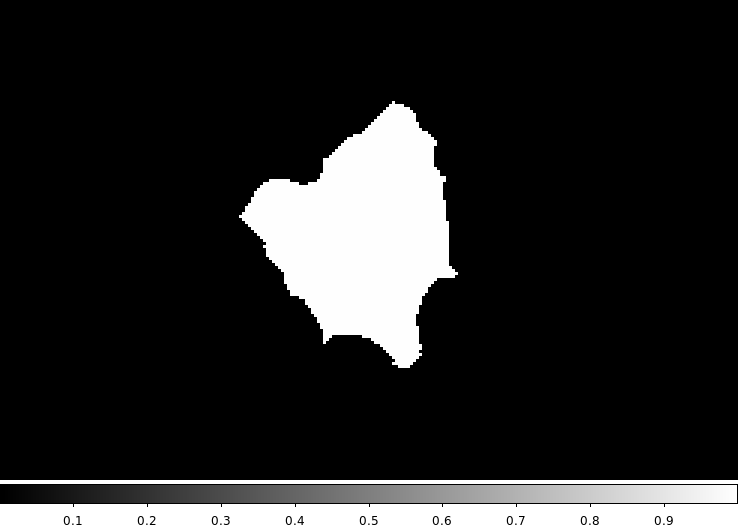

In [19]:
python pathfinder_2.py tmpdir/acisf02233_broad_thresh_000120_000120_flux.fits 12.cell 2465 1684

ds9 12.cell -pan to 2465 1684 image -zoom 3 \
  -saveimage png ds9_05.png -quit

display < ds9_05.png 

### Nearby source

Eventually then the 2nd correlation peak is processed.  It now uses the scale=16 \_flux.fits file.  This blurs out the bright point source much more.  Now when the `local_max__` routine starts to search for the local max in the flux image, it wanders far away from the starting locaion up the slope of the flux image until it reaches the same local max location.  

In [20]:
cat << EOM > pathfinder.py
import sys
infile=sys.argv[1] # "tmpdir/acisf02233_broad_thresh_000160_000160_flux.fits"
x0=int(sys.argv[2]) # 2500
y0=int(sys.argv[3]) # 1689

from pycrates import read_file
img = read_file(infile).get_image().values

# Starting location
xmax = x0-1  # C-style index
ymax = y0-1  # C-style index
maxval = img[ymax][xmax]

while True:
    imax = None
    jmax = None

    for ii in [-1, 0, 1 ]:
        for jj in [-1, 0, 1 ]:
            if img[ymax+jj][xmax+ii] > maxval:
                imax = ii
                jmax = jj
                maxval = img[ymax+jj][xmax+ii]
                
    if imax is None:
        break  # Max didn't move so we're done    

    print("image; line({},{},{},{}) # line=0 0 width=2".format(xmax+1,ymax+1, xmax+imax+1,ymax+jmax+1))    
    
    # Update max location
    xmax = xmax + imax
    ymax = ymax + jmax
    
EOM

python pathfinder.py tmpdir/acisf02233_broad_thresh_000160_000160_flux.fits 2500 1689 > path.reg

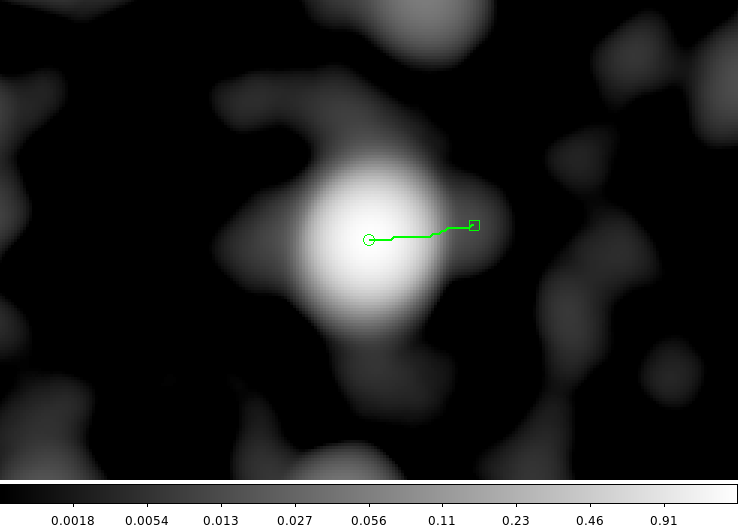

In [21]:
ds9 tmpdir/acisf02233_broad_thresh_000160_000160_flux.fits -scale log \
  -pan to 2465 1684 image -zoom 3 \
  -region path.reg \
  -regions command "image;point(2465,1684) # point=circle" \
  -regions command "image;point(2500,1689) # point=box" \
  -saveimage ds9_07.png -quit 

display < ds9_07.png

The correlation maximum (square) is shifted to the location of the flux maximum (circle).

This is the same location as the source already identified; just now in the scale=16 image.

The location of this flux max in the scale=16 image is then used to determine the cell size.  Since it's a bigger
smoothing kernel, the source cell is bigger, but at the same basic location as the previous source.

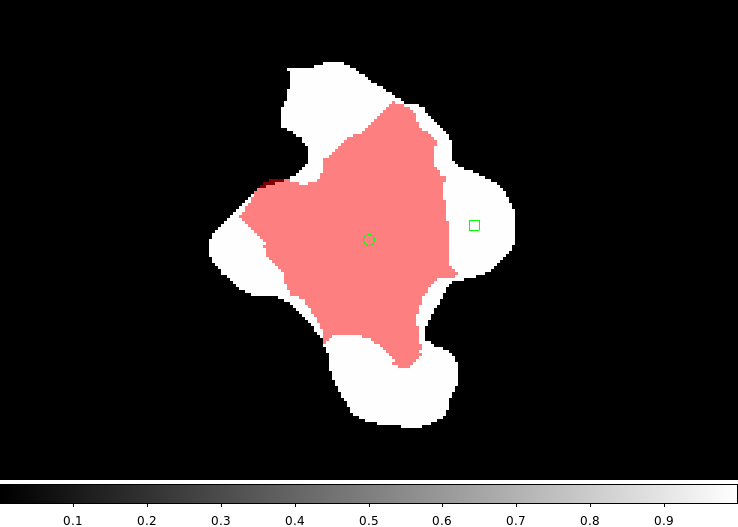

In [22]:
python pathfinder_2.py tmpdir/acisf02233_broad_thresh_000160_000160_flux.fits 16.cell 2465 1684

ds9 16.cell \
  -mask 12.cell -mask transparency 50 \
  -pan to 2465 1684 image -zoom 3 \
  -regions command "image;point(2465,1684) # point=circle" \
  -regions command "image;point(2500,1689) # point=box" \
  -saveimage png ds9_06.png -quit

display < ds9_06.png 

This is why the `cell` image isn't very useful here.  The same starting location was used with two different scales so the image in the cell image was overwritten by the overlapping sources.

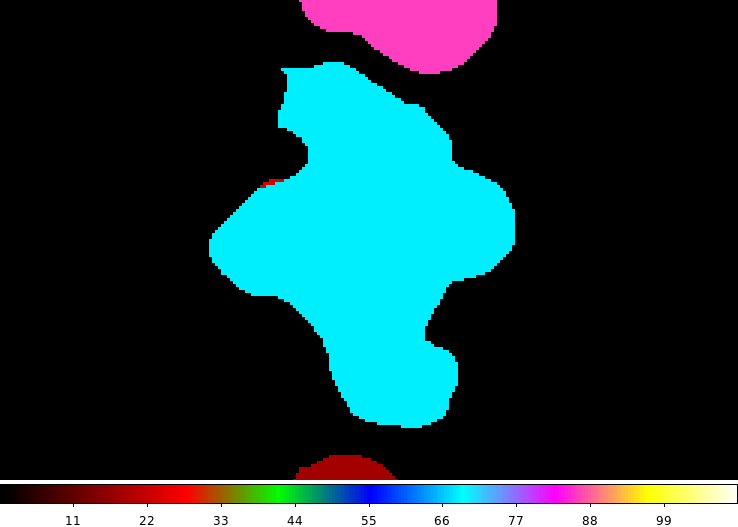

In [23]:
ds9 acisf02233_broad.cell  \
  -pan to 2465 1684 image -zoom 3 \
  -cmap load $ASCDS_INSTALL/contrib/data/6_shades.lut \
  -saveimage png ds9_08.png -quit 

display < ds9_08.png

In this case, the correlation max at scale 16 (square) is not inside the cell for the bright source which used scale 12 (circle).  Which is why the current logic in the code is not triggered to purge the source from the list.

`wr_srclist.c`

```C
  
  /*  Before moving on to the next source, the program 
      performs two final acts: marking all correlation 
      maxima that happen to lie within the current 
      source cell that have yet to be examined, as 
      examined... */
```

and

```C
  /*   ...and rejecting the source if it turns out 
       there is no correlation maximum in the source 
       cell at the PSF scale. 
       */
```